# Week 4: Machine learning 1

Machine learning is a technique for learning patterns in data that enable computers to make decisions and predictions. It's probably one of the hottest skills to master as a scientist or engineer in research or industry today. This week, we'll get an overview of what machine learning is, what it can be used for and what its limits are. Without worrying too much about what goes on behind the scenes, we will play around with a few classifiers in Python and test model performance using cross validation. The exercises today cover:

* Feature representation
* Model fitting
* Model evaluation
* Prediction results

[**Questions**](https://github.com/ulfaslak/computational_analysis_of_big_data_2018_fall/issues) **/** [**Feedback**](http://ulfaslak.com/vent)

## Exercises

We want to predict whether a character is a hero or a villain from information that we can extract from their markup. This is a large problem that includes some data wrangling, model fitting and a bit of evaluation. Therefore the problem is split into parts.

### Part 1: Feature representation
In it's raw format, the data cannot be given to a machine learning algorithm. What we must do is extract features from the data and put them into a structured format. This is the same as what we did when we looked at a dog (the data) and extracted into a matrix whether it was fluffy, sad looking, etc. (the features). The feature we will extract here is **team alliances**.

We can represent the team alliances of each character as a row in a matrix where each column corresponds to a particular team. That should look something like this (numbers are made up):

<img src="http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_boa.png" width="400"/>

**Note**: The following exercises relies on the dataset you produced in Ex. 3.1.2 (character markup stored on your computer). If you didn't manage to produce the dataset [use mine](https://github.com/ulfaslak/computational_analysis_of_big_data_2018_fall/tree/master/data) and go back and complete it at a later time so that you get the most out of this session.

> **Ex.4.1.1**: Write a function called `get_alliances` that takes the name of a character and returns a list of teams that the character is allied with. Print the alliances of Iron Man.

*Hint: There is a place in the character markup where you'll find the team affiliations and you want to write some code that can extract that. The affiliations are not always listed the same way so you should probably try to eyeball some of the documents to get a feel of how the formatting can look.

In [3]:
import requests as rq
import os
import urllib3 
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning
def get_marvel_character_list(character_type):
    """Returns a set of one type of Marvel Characters (either superheroes or supervillains)
    
    Using the rq.get() method, request the WikiPedia page containing the list of either character type
    defined by the user, then store the .json result into a dictionary, with the continue keyword if it 
    exists. In a loop, keys into query and categorymembers to access title, which contains the character
    name to be added into a set, requests another query with the continue key. If there is a KeyError,
    Then there is no more continue data to be keyed into.
    
    Args:
        characters: string describing the type of marvel characters ("superheroes or supervillains")
        
    Returns: 
        list: a set of the character names
    """
    
    group = set()  
    
    wpage = r"https://en.wikipedia.org/w/api.php?"
    action = r"action=query"
    format = r"format=json"
    list = r"list=categorymembers"
    title = r"cmtitle=Category:Marvel_Comics_%s" % character_type
    url = wpage + "&".join([action,format,list,title])
    
    data = rq.get(url).json()
    cont = data['continue']['cmcontinue']
    
    for entry in data['query']['categorymembers']:
        group.add(entry['title'])
    while True:
        try:
            data = rq.get(url + "&cmcontinue=%s" % cont).json()
            cont = data['continue']['cmcontinue']

            for entry in data['query']['categorymembers']:
                group.add(entry['title'])
        except KeyError:
            break
    return group
def make_groups(**offline):
    """Partitions the three main groups
    
    Defines global variables for each then makes the superheroes and supervillain
    sets. Forms the ambiguous set which is the intersection then, subtracts them 
    from each group.
    """
    
    global superheroes, supervillains, ambiguous
    
    """Must have stored markup data on a directory"""
    if offline:
        for group, faction in enumerate(['superheroes', 'supervillains', 'ambiguous']):
            faction_chars = [c[:-4] for c in os.listdir('characters/%s' % faction)]
            
            if group == 0:
                superheroes = set(faction_chars)
                
            elif group == 1:
                supervillains = set(faction_chars)
            
            elif group == 2:
                ambiguous = set(faction_chars)
    else:          
        superheroes = get_marvel_character_list("superheroes")
        supervillains = get_marvel_character_list("supervillains")
        ambiguous = superheroes.intersection(supervillains)
        superheroes -= ambiguous
        supervillains -= ambiguous

make_groups(offline=True)

In [4]:
def verify_fname(string):
    """Replaces illegal file name characters in the string to legal ones"""

    if string.find(r'"') != -1:
        string = string.replace(r'"', "",2)
    if string.find(r'/') != -1:
        string = string.replace(r'/','or')
    if string.find(r':') != -1:
        string = string.replace(r':', '')
    return string

In [5]:
import re
import os
def get_alliances(char):
    """Returns a list of alliances of char from markup
    
    Changes char to a valid file name to access its .txt file. Store markup into a variable to be searched by
    two RegEx's. If there is an IndexError, then char has no alliances (the list is empty). 
    
    """
    char = verify_fname(char)
    for faction in ['superheroes', 'supervillains', 'ambiguous']:
        faction_chars = [c[:-4] for c in os.listdir("characters/%s" % faction)]
        if char in faction_chars:
            break

    with open("characters/%s/%s.txt" % (faction,char)) as f:
        line = f.read()
        
    try:
        text = re.findall(r"\| *alliances[\w\W]+?\\n\|", line)[0]
    except IndexError:
        return
    
    a_list = re.findall(r"\[\[(.*?)\]\]", text)
    
    alliance_list = []
    
    """In a case that an element of a list is split into two parts by '|', take the second one (cleaner)"""
    for x in a_list:
        if x.find("|") != -1:
            a = x.split("|")
            alliance_list.append(a[1])
        else:
            alliance_list.append(x)
            
    return alliance_list
    



In [6]:
print(get_alliances("Captain America"))

['All-Winners Squad', 'Avengers', 'Avengers Unity Division', 'Illuminati', 'Invaders', 'Landau, Luckman, and Lake', 'New Avengers', 'Project: Rebirth', 'Redeemers', 'S.H.I.E.L.D.', 'Secret Avengers', 'Secret Avengers', 'Secret Defenders', 'U.S. Army', 'New York City Police Department']


> **Ex.4.1.2**: Produce a sorted list called `all_teams` that contains all teams in the entire Marvel universe. Print the first 10.

In [51]:
global all_heroes,conflicts
all_heroes = sorted(superheroes.union(supervillains, ambiguous))

def clean_data(data):
    for item in data.copy():
        if item.find("Category") != -1 or item.find("List of") != -1:
            data.remove(item)
            
clean_data(all_heroes)
len(all_heroes)


1963

In [57]:
def all_teams(**progress):
    
    global all_heroes
    conflicts = set()
    alliances = set()

    for name in all_heroes:
        
        if progress:
            print ("Getting alliance for %s" % name)
            print ("================================================")
            
        try:
            teams = get_alliances(name)
            for team in teams:
                alliances.add(team)
        except (TypeError,IOError):  # If error, the 'alliances' field was not found in the markup.             
            conflicts.add(name)      # Delete later from alliances
            continue
            
    all_heroes = set(all_heroes) - conflicts
    all_heroes = sorted(all_heroes)
    
    return alliances

all_alliances = all_teams()

> **Ex.4.1.3**: Write a function that takes the name of a character and returns a vector representation of the team alliances for that character. The length of the returned list will be `len(all_teams)` and have 0s in the places corresponding to teams that the character is not on, and 1s in the places corresponding to teams the character is on. Print the sum of the list returned when the input to the function is Iron man.

In [62]:
def alliance_vector(character):
    alliances = get_alliances(character)
    
    global all_alliances
    
    team_vector = []
    for team in all_alliances:
        if team in alliances:
            team_vector.append(1)
        else:
            team_vector.append(0)
    return team_vector


> **Ex. 4.1.4**: Create the team alliance matrix for the data. This is your feature matrix for the classification problem you will solve later in this exercise set. Therefore, you should also—in a seperate *target* array—store whether characters are heros (denote by 1) or villains (denote by 0). For now, skip ambiguous characters, but write your code in such a way that it won't be too hard to redo this for ambiguous characters. Skip characters that have no team alliances. Print the shapes of your matrix and target array.

In [156]:
import pandas as pd
def alliance_matrix(**write):
    
    global all_heroes
    
    def get_targets():
        
        targets = []

        for character in all_heroes:
            if character in superheroes:
                targets.append(1)
            elif character in supervillains:
                targets.append(0)
            elif character in ambiguous:
                targets.append(2)
        return np.array(targets)
    
    def get_features(**progress):
        
        features = []

        for hero in all_heroes:
            if progress:
                print ("Getting alliance vector for %s" % hero)
            features.append(alliance_vector(hero))

        return np.array(features)
    
    def clean_data(df):
        """Gets the indices (names) which have no alliances and drop them from the DataFrame"""
        to_clean = df.iloc[:,:-1]  # Take the DataFrame without the target array.
        df = df.drop(to_clean[to_clean.sum(1) == 0].index,axis=0)            
        
        return df
    
    targets = get_targets()
    features = get_features()
    
    data = pd.DataFrame(data=features, index=all_heroes, columns=all_alliances) 
    data['faction'] = pd.DataFrame(data=targets,index=all_heroes)                # Appends the target array to the end of df
    
    data = clean_data(data)
    
    if write:
        data.to_csv("marvel.csv",sep=',',encoding='utf-8')
        
    return data

marvel = alliance_matrix(write=True)

In [155]:
marvel

,New Charles Xavier School Students,British army,The Crew,Masters of Evil,Maggia,Phalanx,"""Defenders for a Day""",Gamma Corps,Hand,Weapon X,...,Brotherhood,Resistants,Avengers,Champions of Xandar,French Foreign Legion,MI: 13,Great Lakes Avengers,All-New Exiles,Witches,faction
Abigail Brand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Abner Jenkins,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Abomination (comics),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abraham Cornelius,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Absorbing Man,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adam Warlock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Adept (comics),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Adrienne Frost,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ahab (comics),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aikku Jokinen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Part 2: Model fitting

> **Ex. 4.2.1**: Train a classifier on all of your data and test its accuracy.

>* If your team alliance matrix is `X_ta` and your target array is `y_ta` you can do this by instantiating a model like:
>
        from sklearn.naive_bayes import BernoulliNB
        model = BernoulliNB()
        model.fit(X_ta, y_ta)  # <--- This is the training/fitting/learning step
        
> The `BernoulliNB` is a version of the Naive Bayes classifier which associates certain features with labels and asks what the probability of a label for a data point is given its features. You are free to use any other classifier if you want. Popular ones are trees, random forests, support vector machines, feed forward neural networks, logistic regression, and the list goes on. With `sklearn`, they are just as easy to employ as the `BernoulliNB` classifier.


>1. Test the accuracy of your model. You can use the `.predict` method on the `model` object to get predictions for a matrix of data points. Report the accuracy of your model on the same data that you trained the model on, alongside the baseline accuracy of a "dumb" model that only guesses for the majority class.

>2. Report the precision, recall and F1 scores, with respect to the minority class (heroes). `sklearn` has implementations that you can use if you are short for time. Extra credit for doing it using only basic linear algebra operations with `numpy`, though.

In [189]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

modelNB = BernoulliNB()

# feature array
marvel_features = marvel.iloc[:,:-1]

# target array
marvel_target = marvel.faction

modelNB.fit(marvel_features, marvel_target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

ValueError: Expected 2D array, got 1D array instead:
array=[1 2 0 ... 1 1 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [187]:
def predict_on_model(model,data):

    y_pred = model.predict(data)
    
    metrics = [accuracy_score(), 
               precision_score(average='micro'),
               f1_score(average='micro'),
               recall_score(average='micro')]
    
    print("Reporting metrics:")
    for metric in metrics:
        print(metric(data, y_pred))
    
predict_on_model(model,marvel.faction)

ValueError: Expected 2D array, got 1D array instead:
array=[1 2 0 ... 1 1 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Part 3: Model evaluation

> **Ex. 4.3.1**: Investigate how well your model generalizes. You may have noticed that the performance seemed a little too good to be true in Ex 4.2.1.
1. Why did you get such a high accuracy in the previous exercise?
2. Split your data into a test and training set of equal size. Train the model only on the training set and report its accuracy and F1 scores (for both classes) on both the training and test sets.
3. Comment on the difference you observe.

> *Hint: Watch out for unbalanced class proportions! You may want to randomly reorder the rows of your datapoints and target labels so your training and test sets have the same amount of heroes and villains.*

In [317]:
from sklearn.utils import shuffle

model2 = BernoulliNB()
alliance_matrix = shuffle(ml_data)

training_set = alliance_matrix.iloc[:len(alliance_matrix)//2,:]
test_set = alliance_matrix.iloc[(len(alliance_matrix)//2):,:]

model2.fit(training_set,training_set.faction)

training_pred = model2.predict(training_set)
test_pred = model2.predict(test_set)

print accuracy_score(training_set.faction, training_pred)
print accuracy_score(test_set.faction, test_pred)

0.9056603773584906
0.9010989010989011


> **Ex. 4.3.2**: Implement cross validation. The performance of a classifier is strongly dependent on the amount of data it is trained on. In Ex. 4.3.1 you train it on only half of the data and test it on the other half. If you rerun that code multiple times, with random 50/50 partitions, you are gonna see a lot of uncertainty in performance. Cross validation solves this problem by training on a larger subset of the data and testing on a smaller one, and taking the average performance over K-folds of this process.
1. Implement cross validation over $K=10$ folds. For each fold you must record the training and test accuracies. In the end, visualize the distributions of test- and training accuracy as histograms in the same plot. It's important that you comment on the result.

In [182]:
def partition(ml_data,k):
    parted = []
    
    #number of elements in each k partitions
    num = len(ml_data)//k 
    
    for i in range(k):
        
        #Partition by the row. middle is test data and start+end is training data
        #.iloc[row_start:row_end, column_start:column_end] column_end is excluded
        start = ml_data.iloc[:(i*num),:]
        middle = ml_data.iloc[i*num:(i+1)*num,:]
        end = ml_data.iloc[(i+1)*num:,:]
        
        parted.append((middle,pd.concat([start,end])))
        
    #list of tuples of (test_data, training data)
    return parted 


In [179]:
import numpy as np
def cross_validation(ml_data,k):
    #define a new BernoulliNB model
    model = BernoulliNB()
    
    #parititon DataFrame into k folds 
    folds = partition(ml_data,k)
    
    #stores the accs to plot later
    train_accs = []
    test_accs = []
    
    index = 1
    for test_data, train_data in folds:
        
        headline = "Fold %d" % index
        print (headline + "\n" + "-"*len(headline))
        
        #define the target arrays of the current train and test data
        train_target = train_data.faction
        test_target = test_data.faction
        
        #Set train data and test data to not include the target array
        train_data = train_data.iloc[:,:-1]
        test_data = test_data.iloc[:,:-1]
        
        #fit, train, learning step based on current train data
        model.fit(train_data,train_target)
        
        #predict on the train data and test data
        train_pred = model.predict(train_data)
        test_pred = model.predict(test_data)
        
        #make the train_data and train_pred to be both numpy.arrays for comparison.
        train_data = np.array(train_target)
        test_data = np.array(test_target)
        
        #solves for accuracy of each
        train_acc = accuracy_score(train_data,train_pred)
        test_acc = accuracy_score(test_data,test_pred)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print ("    train acc: %.4f" % train_acc)
        print ("    test acc: %.4f\n" % test_acc)
        
        index += 1
        
    print ("average train accuracy: %.4f\naverage test accuracy: %.4f" % (np.mean(train_accs),np.mean(test_accs)))
    
    return train_accs, test_accs
        

Fold 1
------
    train acc: 0.8366
    test acc: 0.8047

Fold 2
------
    train acc: 0.8323
    test acc: 0.7656

Fold 3
------
    train acc: 0.8358
    test acc: 0.7656

Fold 4
------
    train acc: 0.8358
    test acc: 0.7422

Fold 5
------
    train acc: 0.8375
    test acc: 0.7578

Fold 6
------
    train acc: 0.8358
    test acc: 0.8281

Fold 7
------
    train acc: 0.8392
    test acc: 0.7422

Fold 8
------
    train acc: 0.8366
    test acc: 0.7500

Fold 9
------
    train acc: 0.8358
    test acc: 0.7969

Fold 10
-------
    train acc: 0.8332
    test acc: 0.7734

average train accuracy: 0.8359
average test accuracy: 0.7727


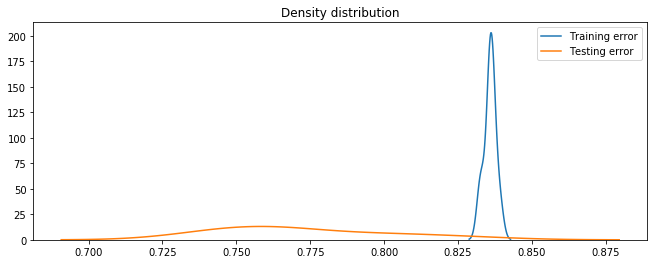

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

train_accs, test_accs = cross_validation(marvel,10)


plt.figure(figsize=(11,4))

sns.kdeplot(train_accs, label='Training error')
sns.kdeplot(test_accs, label='Testing error')
plt.title("Density distribution")
plt.legend(loc=0)

plt.show()

### Part 4: Predicting good vs. evil

>**Ex. 4.4.1**: Let's put our classifier to use!
* Retrain your model on all of your data.
* Create a team alliance representation of the ambiguous characters
* Use the model the estimate the probability that each character is a villain (let's call this *villainness*). You can use the `.predict_proba` method on the model to get probability estimates rather than class assignments.
* **Visualize the "heroness" distribution for all ambiguous characters**. Comment on the result.

In [329]:
amb_heroes = ml_data[ml_data.faction == 2]
model.fit(alliance_matrix,alliance_target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [332]:
amb_guesses = model.predict_proba(alliance_matrix)

In [344]:
amb_prob = []
hero_prob = []
villain_prob = []

#Measure villainness of ambiguous characters
amb_names = amb_heroes.index

for char in amb_guesses:
    for num,prob in enumerate(char):
        if num == 0:
            villain_prob.append(prob)
        elif num == 1:
            hero_prob.append(prob)
        elif num == 2:
            amb_prob.append(prob)

print "Villain probability\n"+"="*len("Villain probability")
for name,prob in zip(amb_names, hero_prob):
    print "   %38s: %.2f%%" % (name, prob*100)


Villain probability
                    Tricephalous (comics): 42.89%
                       Strongman (comics): 42.91%
                               Black Bolt: 40.95%
                Protector (Marvel Comics): 46.45%
                    Match (Marvel Comics): 38.64%
                  Cat-Man (Marvel Comics): 30.35%
            Mastermind (Martinique Jason): 22.57%
                              Leila Davis: 67.89%
                              Master Mold: 36.72%
                            Carol Danvers: 0.01%
                  Electro (Marvel Comics): 5.55%
                                 She-Hulk: 0.03%
                              Tyler Stone: 46.59%
                           Hiro Takachiho: 36.76%
                             Eel (comics): 25.08%
                             Leo (comics): 60.53%
                              Elloe Kaifi: 53.82%
                         Maximus (comics): 36.72%
                        Stingray (comics): 14.62%
                         Big Man 

Text(0,0.5,'Density')

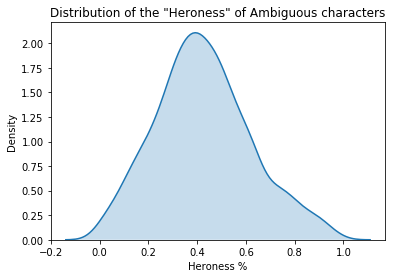

In [346]:
plt.title("Distribution of the \"Heroness\" of Ambiguous characters")
ax = sns.kdeplot(hero_prob,shade=True)
ax.set_xlabel("Heroness %")
ax.set_ylabel("Density")